# Channels and Posterior Vulnerability (part 2)

In this part as well as the next one are gonna examine a couple of variations of the original _Three Prisoners_ problem. The first one is:

## What if the warden uses a biased coin to answer the question?

In the classic version of the problem Alice says to the warden

>...If I'm pardoned, chose randomly to name Bob or Charlie.

which has basically the same meaning as

>...If I'm pardoned, flip a **fair coin** and if it lands on heads says Bob's name otherwise say Charlie's.

But what would happen if the warden flipped a **biased coin** and made his choice according to that?

A biased coin is characterized by a probability $p$. For example if $p = \frac{2}{3}$ then it means that the coin lands on heads 2 out of 3 times and on tails 1 out of 3.

If you haven't guessed it already, we're gonna experiment with a couple different values of $p$ and for that we're gonna define the `get_W(p)` and the `get_distribution(p)` function that are gonna speed things up a little. 

For this variation we are gonna keep assuming that **the pardoned prisoner is chosen uniformly**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from qif import *
except: # install qif if not available (for running in colab, etc)
    import IPython; IPython.get_ipython().run_line_magic('pip', 'install qif')
    from qif import *

In [2]:
def get_W(p):
    C = np.array([
        [0, p, 1-p],
        [0, 0,   1],
        [0, 1,   0],
    ])
    return C

def get_distribution(p):
    return np.array([p, (1-p)/2,(1-p)/2])

`get_W(p)` takes as input a probability $p$ and creates the channel matrix $W$ (as discussed in the previous part) with the only difference that now the warden uses a biased coin characterized by $p$.

`get_distribution(p)` takes as input a probability $p$ and creates a distribution $\pi$ where:
 - if $p=1/3$, then you get the uniform distribution with each prisoner being chosen with a probability of $1/3$. 
 - if $p > 1/3$, then the first prisoner (Alice) is more likely to be pardoned than any of the other two. 
 - if $p < 1/3$, then the first prisoner (Alice) is the least likely of all to be pardoned.

Now consider the following cases.

### Biased coin with $p = \frac{2}{3}$

Let's define $W$, and the prior distribution $\pi$ in python.

In [3]:
W = get_W(2/3)
print("W\n", W)
pi = get_distribution(1/3)
print("pi\n", pi)

W
 [[0.         0.66666667 0.33333333]
 [0.         0.         1.        ]
 [0.         1.         0.        ]]
pi
 [0.33333333 0.33333333 0.33333333]


Now how does this change our answer to the questions we're interested in? Let's quickly remember these questions.

>1. Given the warden's answer, what is the probability of correctly guessing the pardoned prisoner?
>2. Is the warden’s answer useful for Alice?

For question 1, as we said in the previous part, the answer is basically given by the posterior vulnerability of $W$. Let's also print the prior vulnerability. 

In [4]:
print("Prior Bayes vulnerability:", measure.bayes_vuln.prior(pi))
print("Posterior Bayes vulnerability =", measure.bayes_vuln.posterior(pi, W))

Prior Bayes vulnerability: 0.33333333333333337
Posterior Bayes vulnerability = 0.6666666666666666


We can see that it is exactly the same as in the original problem, where the coin was not biased. Hmm, that looks a bit suspicious... 

For question 2, we're also gonna need the posteriors distribution matrix $P$.

In [5]:
P = channel.posteriors(W, pi)
print(P)

[[ nan 0.4  0.25]
 [ nan 0.   0.75]
 [ nan 0.6  0.  ]]


Here, the answer is basically given by $p(X = A | Y = y)$, by examining it for all values of $y$. There are two possible values for $y$ and these are $B$ and $C$. Now, $p(X = A | Y = B)$ corresponds to $P$'s first-row-second-column element which is $0.4$ and $p(X = A | Y = C)$ corresponds to $P$'s first-row-third-column element which is $0.25$. So from that we can deduct that if the warden says Bob's name then Alice has a $0.4$ chance of surviving but if the warden says Charlie's then it goes down to $0.25$. So here the warden's answer is somewhat useful for Alice, meaning that it updates her knowledge about the probability of her surviving. 

### Biased coin with $p = \frac{3}{4}$

For question 1, doing the same thing as before we see that 

In [6]:
W = get_W(3/4)
print("W\n", W, "\n")
print("Prior Bayes vulnerability:", measure.bayes_vuln.prior(pi))
print("Posterior Bayes vulnerability =", measure.bayes_vuln.posterior(pi, W))

W
 [[0.   0.75 0.25]
 [0.   0.   1.  ]
 [0.   1.   0.  ]] 

Prior Bayes vulnerability: 0.33333333333333337
Posterior Bayes vulnerability = 0.6666666666666666


We see that again, the posterior vunlerability of $W$ is the same. This implies that possibly, no matter the value of $p$, $V(\pi, W)$ stays the same. This indeed can be experimentally verified by trying different values of $p$ and using python to plot the results. But before that, take a few moments to try yourself a few different values for the p parameter of `get_W(p)` in the cell above and rerunning it.

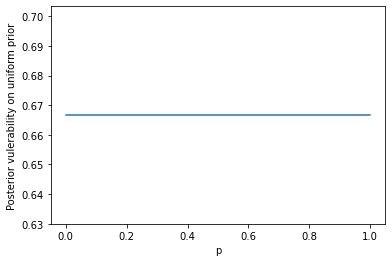

In [7]:
ps = np.linspace(0, 1, 100)
plt.plot(ps, [measure.bayes_vuln.posterior(get_distribution(1/3), get_W(p)) for p in ps])
plt.xlabel('p')
plt.ylabel('Posterior vulerability on uniform prior')
None

Here we clearly see that $V(\pi, W)$ indeed stays the same for all possible values of $p$. Which means that no matter what $p$ the warden uses to determine his answer, **our best guess** will always succeed with probability $\frac{2}{3}$. We could say that all $W$ defined this way, have the same vulenrability against someone who tries to guess the pardoned prisoner in one try.

To get a better insight of why this is happening take a look at the following piece of code. For each `p` from $0$ to $1$, it prints the `p` parameter itself, then the distribution $p_Y(y)$ for $y=B$ or $C$ (remember that Alice's name never pops up meaning $p_Y(A) = 0$, thus $y=A$ is omitted) and then array of the posterior distributions. Its output is in the form of

```
-------------------------------
|    p(Y=B)         p(Y=C)    |
-------------------------------
| p(X=A | Y=B)   p(X=A | Y=C) |
| p(X=B | Y=B)   p(X=B | Y=C) |
| p(X=C | Y=B)   p(X=C | Y=C) |
-------------------------------
```

It also marks for each column its maximum element. 

In [8]:
from print_hyper import print_hyper

for k in range(11):
        print("\np=", k, "/10", sep='')
        print_hyper(get_W(k/10), get_distribution(1/3), highlight_maxima=True)


p=0/10
-------------------
|    0.33    0.67 |
-------------------
|    0.00    0.50 |
|    0.00 -->0.50 |
| -->1.00    0.00 |
-------------------

p=1/10
-------------------
|    0.37    0.63 |
-------------------
|    0.09    0.47 |
|    0.00 -->0.53 |
| -->0.91    0.00 |
-------------------

p=2/10
-------------------
|    0.40    0.60 |
-------------------
|    0.17    0.44 |
|    0.00 -->0.56 |
| -->0.83    0.00 |
-------------------

p=3/10
-------------------
|    0.43    0.57 |
-------------------
|    0.23    0.41 |
|    0.00 -->0.59 |
| -->0.77    0.00 |
-------------------

p=4/10
-------------------
|    0.47    0.53 |
-------------------
|    0.29    0.38 |
|    0.00 -->0.63 |
| -->0.71    0.00 |
-------------------

p=5/10
-------------------
|    0.50    0.50 |
-------------------
|    0.33    0.33 |
|    0.00 -->0.67 |
| -->0.67    0.00 |
-------------------

p=6/10
-------------------
|    0.53    0.47 |
-------------------
|    0.38    0.29 |
|    0.00 -->0.71 |
| --

Notice how the maximum elemnts of each column stay at the same positions as `p` increases. It means that upon observing a specific output $y$, our best guess always stays the same regardless of the distribution of $X$.

Remember that the posterior vulnerability in our case is calculated by 

$$
V(\pi, W) = p_Y(B)\cdot max_B +  p_Y(C)\cdot max_C
$$

where $max_B$ and $max_C$ are the maximum elements of the first and second columns respectively.